In [8]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, add_dummy_feature
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

import warnings
warnings.simplefilter('ignore')

Consider the [Student Performance](http://archive.ics.uci.edu/ml/datasets/Student+Performance) dataset. This dataset contains student demographic, social, school-related features, how many classes they've missed, etc. 

The goal we give ourselves is to predict whether a student will pass (final grade > 12).

We denote $X \in \mathcal{M}_{n,d}(\mathbb{R})$ the feature matrix, containing $n$ samples with $d$ features, and $y \in \{-1,1\}^n$ the label vector where $-1$ encodes `fail` and $1$ encodes `pass`.

In [9]:
student  = pd.read_csv('data/student-mat.csv')
target   = pd.DataFrame(student["G3"])
features = student.drop(["G3"],axis=1)

target = target.applymap(lambda grade: [-1, 1][grade >= 12])

numerical_features = features.apply(LabelEncoder().fit_transform)
normalised_features = add_dummy_feature(StandardScaler().fit_transform(numerical_features))
preprocessed_features = pd.DataFrame(normalised_features , columns=["intercept"] + list(numerical_features.columns) )

X_train, X_test, y_train, y_test = train_test_split(np.array(preprocessed_features), np.ravel(target), test_size = 0.25)

To prediсt results we will use Logistic regression.

Logistic regression consists in finding the parameter $w \in \mathbb{R}^d$ that best fits:
$$
y_i = \begin{cases}
\phantom{-}1 \ \textrm{ if }\ \langle x_{i}, w\rangle \ge 0 \\
-1 \ \textrm{ if }\ \langle x_{i}, w\rangle < 0 
\end{cases}
$$
for all the samples $i$ of the training set (where $a_i$ is the $i^{th}$ line of $A$ and $b_i$ the $i^{th}$ element of $b$). To measure this fit, logistic regression chooses the following loss:

$$
\textrm{LogisticLoss}(y_i, \left\langle x_{i}, w\right\rangle ) = \log \left(1+\exp \left(-y_{i}\left\langle x_{i}, w\right\rangle\right)\right) 
$$

The corresponding optimization problem we will consider is the following:

<div style="background-color: #eceff1; border-left: 0px solid #78909c; padding: 2em; border-radius: 5px;"> 

Minimization of the empirical risk $f$ of the $L_2$-regularized logistic regression model, on the dataset $(X_{\textrm{train}},y_{\textrm{train}})$:

$$
\begin{aligned}
\textrm{min}_{w\in \mathbb{R}^d} \  f(w) 
\ &= \ \textrm{min}_{w\in \mathbb{R}^d} \ \frac{1}{n_{\textrm{train}}} \sum_{i=1}^{n_{\textrm{train}}} f_i(w) \\
&= \ \textrm{min}_{w\in \mathbb{R}^d}\frac{1}{n_{\textrm{train}}} \sum_{i=1}^{n_{\textrm{train}}} \textrm{LogisticLoss}(y_i, \left\langle x_{i}, w\right\rangle ) + \frac{l_2}{2}\|w\|^{2}_2 \\ 
&= \ \textrm{min}_{w\in \mathbb{R}^d}\frac{1}{n_{\textrm{train}}} \sum_{i=1}^{n_{\textrm{train}}} \ln(1+\exp{(-y_i, \left\langle x_{i}, w\right\rangle)}) + \frac{l_2}{2}\|w\|^{2}_2,
\end{aligned}
$$

where $l_2 \ge 0$ is the $L_2$ regularization coefficient.
</div>

**Where did this objective function come from?**

Logistic regression correctly evaluates the probability of belonging of each object to classes.

---

Assume, that we want to have function, which will evaluate probabilities of the belonging of each object to classes, let it will predict probability of belonging to positive class $p(y=+1|x)$.
Thus, we want:
$$argmin_{b \in R} \frac{1}{n} \sum\limits_{i=1}^{n}L(y_i, b) \approx p(y=+1|x)$$

Assume, that algorithm $b(x)$ predict probabilities, then it must be consistent with the samples: probability of $x_i$ with label $y_i$:

$$b(x_i)^{[y_i=+1]}(1-b(x_i))^{[y_i=-1]}$$

Log-likelihood of sampling:
\begin{equation}
- \sum\limits_{i=1}^{l}\left[I\left(y_i=+1\right)log\left(b\left(x_i\right)\right)+I\left(y_i=-1\right)log\left(1-b\left(x_i\right)\right)\right] (1)
\end{equation}

Thus, we will use previous equation as objective function.

---

**Show, that its optimal answer is $p(y=+1|x)$:**

$$E\left[L(y,b)|x\right]=E\left[-I\left(y_i=+1\right)log\left(b\left(x_i\right)\right)-I\left(y_i=-1\right)log\left(1-b\left(x_i\right)\right)\right|x]$$ 
$$= -log(b(x))p(y=+1|x) - (1-p(y=+1|x))log(1-b(x))$$

Differentiate by $b$:
$$\frac{-p(y=+1|x))}{b}+\frac{1-p(y=+1|x)}{1-b} = 0 \to$$
$$b = p(y=+1|x)$$

---

Next, we want the answers of $b(x)$ to lie on the segment $\left[0,1\right]$, this can be guaranteed with sigmoid function:
$$b(x)=\sigma(\langle w,x \rangle)= \frac{1}{1+ exp(-\langle w,x \rangle)}$$

Put this into (1):
$$L = \sum\limits_{i=1}^{l}log(1+exp(-y_i\langle w, x_i\rangle))$$

On this we are done with the theory and move on to the code.

In [48]:
import numpy as np

class LogisticRegression:

    def __init__(self, l2=0.05, max_iter=100):
        
        self.l2 = l2
        self.max_iter = max_iter

    def fit(self, X, y):

        n = len(y)

        # Smoothness constant
        L = 0.25 * max(np.linalg.norm(X,2,axis=1))**2 + self.l2

        # Strong convexity constant
        mu = self.l2
        
        # Initialisation of the solver
        x0=np.zeros(X.shape[1])
        
        def grad(w, i=None):
   
            if i is None: # return batch gradient
                output = -y / (1 + np.exp(y * np.dot(X, w)))
                output = sum(np.diag(output)) / n @ X
                output += self.l2 * w
                
            else: # return partial gradient associated the datapoint (A[i], b[i])
                output = -y[i] / (1 + np.exp(y[i] * np.dot(X[i], w)))
                output = output * X[i]
                output += self.l2 * w
                
            return output
        
        def SGD(x0, grad, max_iter, n, L, mu):
            
            w = x0
            w_tab = np.copy(w)

            for k in range(max_iter):
                
                step_size = 2 / (L + mu * (k + 2))
                
                idx = np.random.randint(0, n)
                w = w - step_size * grad(w, idx)

                if k%n == 0: # each completed epoch
                    w_tab = np.vstack((w_tab, w))

            return w, w_tab

        # Last iterate of the optimization, and table of all the iterates
        self.coef_, self._coef_tab = SGD(x0, grad, self.max_iter, n, L, mu)
        
        self._empirical_risk = lambda w: sum(self._logistic_loss(X, y, w))/n \
            + 0.5 * self.l2 * np.linalg.norm(w, 2)**2 


    def decision_function(self, X):

        return 1.0/(1 + np.exp(-np.dot(X, self.coef_)))

    def predict(self, X):

        return [[-1, 1][p >= 0.5] for p in self.decision_function(X)]

    def score(self, X, y):

        return np.sum(self.predict(X) == y)/len(y)

    def _logistic_loss(self, X, y, w):
        
        return np.log(1 + np.exp(-y*np.dot(X, w)))

In [49]:
clf_saga = LogisticRegression(l2=0.01, max_iter=30*len(X_train))
clf_saga.fit(X_train, y_train)

clf_saga.score(X_test, y_test)

0.8585858585858586

Build a learning curve:

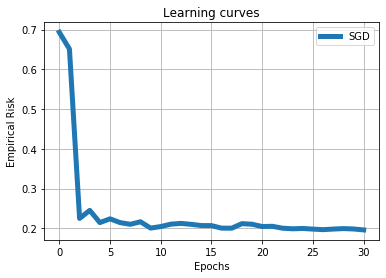

In [50]:
x_tab = clf_saga._coef_tab
curve = [clf_saga._empirical_risk(x) for x in x_tab]

plt.plot(curve, linewidth=5.0, linestyle="-", label='SGD')
plt.grid(True)
plt.legend(loc='best')
plt.ylabel('Empirical Risk')
plt.xlabel('Epochs')
plt.title('Learning curves')

plt.show()